# Summary
- mincorr and minlinreg are similar. maxcorr and maxlinreg are similar. 
- spearman among different layers is lower (even goes negative) in lower layers for:
    - bert_large
    - openai
    - bert_base
  
  but not true for elmo or calypso
- intermediate layers appear most similar to the next and previous layer of the same model
- lower layers (eg. in bert) are more correlated with lower layers in other models
- in the larger bert, new layers are effectively inserted between old ones (see heatmap), although the last few layers don't seem to follow this

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns

In [13]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results8_"
res_fname = {method : base + method for method in 
                {"maxcorr", "mincorr", "maxlinreg", "minlinreg", "cca", "lincka", "rbfcka"}}

res_d = {}
res_d["maxcorr"] = json.load(open(res_fname["maxcorr"], "r"))
res_d["mincorr"] = json.load(open(res_fname["mincorr"], "r"))
res_d["maxlinreg"] = json.load(open(res_fname["maxlinreg"], "r"))
res_d["minlinreg"] = json.load(open(res_fname["minlinreg"], "r"))

network_l = [network for network in res_d["maxcorr"]]

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(res_d["maxcorr"][network])

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [3]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [4]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = [neuron[0] for neuron in res_d[method][network]]

In [5]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [6]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_large_cased_0
            maxcorr  maxlinreg  minlinreg   mincorr
maxcorr    1.000000   0.648580  -0.205201 -0.265457
maxlinreg  0.648580   1.000000   0.267656  0.176797
minlinreg -0.205201   0.267656   1.000000  0.841917
mincorr   -0.265457   0.176797   0.841917  1.000000
bert_large_cased_1
            maxcorr  maxlinreg  minlinreg   mincorr
maxcorr    1.000000   0.966639   0.215490 -0.017512
maxlinreg  0.966639   1.000000   0.278610  0.035103
minlinreg  0.215490   0.278610   1.000000  0.744525
mincorr   -0.017512   0.035103   0.744525  1.000000
bert_large_cased_2
            maxcorr  maxlinreg  minlinreg   mincorr
maxcorr    1.000000   0.977871   0.435666  0.115634
maxlinreg  0.977871   1.000000   0.452293  0.131480
minlinreg  0.435666   0.452293   1.000000  0.739880
mincorr    0.115634   0.131480   0.739880  1.000000
bert_large_cased_3
            maxcorr  maxlinreg  minlinreg   mincorr
maxcorr    1.000000   0.980589   0.348838  0.098167
maxlinreg  0.980589   1.000000   0.37661

            maxcorr  maxlinreg  minlinreg   mincorr
maxcorr    1.000000   0.887033   0.633663  0.415716
maxlinreg  0.887033   1.000000   0.723367  0.521602
minlinreg  0.633663   0.723367   1.000000  0.817193
mincorr    0.415716   0.521602   0.817193  1.000000
xlnet_large_cased_22
            maxcorr  maxlinreg  minlinreg   mincorr
maxcorr    1.000000   0.758273   0.500716  0.335521
maxlinreg  0.758273   1.000000   0.682169  0.504240
minlinreg  0.500716   0.682169   1.000000  0.828760
mincorr    0.335521   0.504240   0.828760  1.000000
xlnet_large_cased_23
            maxcorr  maxlinreg  minlinreg   mincorr
maxcorr    1.000000   0.704952   0.452170  0.309494
maxlinreg  0.704952   1.000000   0.614470  0.424558
minlinreg  0.452170   0.614470   1.000000  0.803794
mincorr    0.309494   0.424558   0.803794  1.000000


### Distributions

In [7]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        corr_ar = np.stack([
            list(notated_neuron[1].values())
            for notated_neuron in res_d[method][network]
        ])
        corr_df = pd.DataFrame(np.abs(corr_ar),
                              columns=[net for net in network_l if net != network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_large_cased_0:

maxcorr

maxcounts
bert_large_cased_1                  981
bert_base_cased_0                    40
calypso_transformer_6_512_base_0      2
openai_transformer_2                  1
dtype: int64

mincounts
xlnet_large_cased_23    687
elmo_4x4096_512_2        67
xlnet_large_cased_20     50
xlnet_large_cased_22     34
xlnet_large_cased_16     32
xlnet_large_cased_19     26
xlnet_large_cased_21     20
xlnet_large_cased_18     19
xlnet_large_cased_17     19
xlnet_large_cased_15     18
elmo_4x4096_512_3         9
xlnet_large_cased_13      9
xlnet_large_cased_14      4
xlnet_large_cased_12      3
bert_base_cased_8         3
xlnet_large_cased_9       2
xlnet_large_cased_3       2
xlnet_large_cased_1       2
bert_base_cased_12        2
xlnet_large_cased_7       2
elmo_4x4096_512_4         2
bert_large_cased_18       2
bert_large_cased_19       2
xlnet_large_cased_11      1
bert_large_cased_22       1
bert_large_cased_24       1
xlnet_large_cased_4       1
elmo_4x4096_512_1 


maxcounts
bert_large_cased_2    955
bert_large_cased_4     69
dtype: int64

mincounts
xlnet_large_cased_23                574
xlnet_large_cased_22                 65
xlnet_large_cased_20                 48
elmo_4x4096_512_2                    43
xlnet_large_cased_15                 31
xlnet_large_cased_21                 30
xlnet_large_cased_16                 29
elmo_4x4096_512_3                    27
xlnet_large_cased_19                 26
xlnet_large_cased_13                 24
xlnet_large_cased_18                 21
xlnet_large_cased_14                 18
xlnet_large_cased_17                 14
xlnet_large_cased_12                  8
elmo_4x4096_512_4                     6
xlnet_large_cased_11                  5
elmo_4x4096_512_0                     4
xlnet_large_cased_8                   4
calypso_transformer_6_512_base_6      4
bert_base_cased_12                    4
xlnet_large_cased_9                   3
xlnet_large_cased_10                  3
bert_large_cased_24              

bert_large_cased_6    703
bert_large_cased_4    321
dtype: int64

mincounts
xlnet_large_cased_23                591
xlnet_large_cased_22                 49
elmo_4x4096_512_2                    47
xlnet_large_cased_20                 37
xlnet_large_cased_16                 34
xlnet_large_cased_15                 31
xlnet_large_cased_19                 26
xlnet_large_cased_14                 20
elmo_4x4096_512_3                    20
xlnet_large_cased_17                 18
xlnet_large_cased_18                 18
xlnet_large_cased_13                 17
elmo_4x4096_512_4                    13
xlnet_large_cased_21                 13
xlnet_large_cased_12                 10
elmo_4x4096_512_0                     9
elmo_original_2                       7
openai_transformer_12                 7
openai_transformer_0                  4
xlnet_large_cased_11                  4
bert_base_cased_12                    4
bert_large_cased_24                   4
bert_base_cased_11                    4
bert

xlnet_large_cased_23                640
elmo_4x4096_512_2                    44
xlnet_large_cased_22                 38
elmo_4x4096_512_3                    34
xlnet_large_cased_15                 26
xlnet_large_cased_20                 26
xlnet_large_cased_16                 23
xlnet_large_cased_19                 20
xlnet_large_cased_21                 18
xlnet_large_cased_17                 16
xlnet_large_cased_14                 14
xlnet_large_cased_13                 11
openai_transformer_0                 10
elmo_original_0                      10
elmo_original_2                      10
xlnet_large_cased_18                  9
elmo_4x4096_512_4                     9
calypso_transformer_6_512_base_6      7
elmo_4x4096_512_0                     6
bert_base_cased_12                    5
xlnet_large_cased_1                   5
xlnet_large_cased_10                  5
openai_transformer_12                 4
openai_transformer_11                 4
xlnet_large_cased_0                   4


          max       min       med
max  1.000000  0.617152  0.816005
min  0.617152  1.000000  0.923290
med  0.816005  0.923290  1.000000

mincorr

maxcounts
bert_large_cased_10                 668
bert_large_cased_8                  355
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                596
elmo_4x4096_512_2                    47
elmo_4x4096_512_3                    44
xlnet_large_cased_22                 35
xlnet_large_cased_16                 27
xlnet_large_cased_20                 26
xlnet_large_cased_15                 20
elmo_original_0                      18
xlnet_large_cased_19                 16
xlnet_large_cased_13                 15
xlnet_large_cased_18                 14
xlnet_large_cased_21                 14
openai_transformer_12                14
elmo_4x4096_512_0                    12
elmo_4x4096_512_4                    11
xlnet_large_cased_17                 11
xlnet_large_cased_14                 11
calypso_transformer_


maxcounts
bert_large_cased_10    655
bert_large_cased_12    369
dtype: int64

mincounts
xlnet_large_cased_23                632
xlnet_large_cased_22                 43
elmo_4x4096_512_2                    42
elmo_4x4096_512_3                    29
xlnet_large_cased_20                 27
xlnet_large_cased_16                 26
openai_transformer_0                 18
xlnet_large_cased_19                 17
elmo_original_0                      14
xlnet_large_cased_15                 14
xlnet_large_cased_17                 13
openai_transformer_12                12
xlnet_large_cased_21                 12
xlnet_large_cased_1                  11
openai_transformer_1                 10
elmo_original_2                      10
elmo_4x4096_512_0                    10
xlnet_large_cased_18                 10
xlnet_large_cased_14                  9
bert_base_cased_12                    8
xlnet_large_cased_13                  8
calypso_transformer_6_512_base_6      7
xlnet_large_cased_2            

xlnet_large_cased_23                665
elmo_4x4096_512_2                    38
openai_transformer_0                 26
xlnet_large_cased_21                 26
xlnet_large_cased_22                 24
elmo_4x4096_512_0                    22
elmo_4x4096_512_3                    22
elmo_original_0                      18
xlnet_large_cased_1                  18
xlnet_large_cased_16                 16
xlnet_large_cased_20                 16
openai_transformer_12                14
xlnet_large_cased_19                 14
xlnet_large_cased_18                 14
xlnet_large_cased_15                 11
openai_transformer_1                  7
xlnet_large_cased_13                  7
xlnet_large_cased_14                  6
xlnet_large_cased_2                   6
calypso_transformer_6_512_base_6      6
elmo_4x4096_512_4                     5
elmo_original_2                       4
xlnet_large_cased_17                  4
xlnet_large_cased_0                   4
openai_transformer_11                 3


          max       min       med
max  1.000000  0.579378  0.599602
min  0.579378  1.000000  0.864125
med  0.599602  0.864125  1.000000


bert_large_cased_16:

maxcorr

maxcounts
bert_large_cased_15                 839
bert_large_cased_17                 184
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                574
elmo_original_0                      39
openai_transformer_0                 36
elmo_4x4096_512_2                    35
elmo_4x4096_512_0                    34
xlnet_large_cased_1                  32
elmo_4x4096_512_3                    31
xlnet_large_cased_22                 31
xlnet_large_cased_2                  19
openai_transformer_1                 18
openai_transformer_12                14
xlnet_large_cased_19                 13
xlnet_large_cased_21                 12
elmo_original_2                      11
xlnet_large_cased_20                 11
openai_transformer_2                 11
xlnet_large_cased_0                  


maxcounts
bert_large_cased_19                 998
bert_large_cased_17                  24
bert_large_cased_20                   1
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                398
elmo_original_0                     100
elmo_4x4096_512_0                    60
openai_transformer_0                 57
xlnet_large_cased_1                  42
elmo_4x4096_512_2                    41
elmo_4x4096_512_3                    37
xlnet_large_cased_2                  31
openai_transformer_1                 28
openai_transformer_12                18
xlnet_large_cased_22                 17
xlnet_large_cased_0                  16
elmo_original_2                      11
bert_base_cased_0                    11
elmo_4x4096_512_1                    10
bert_base_cased_1                    10
elmo_4x4096_512_4                     9
xlnet_large_cased_21                  9
calypso_transformer_6_512_base_6      9
calypso_transformer_6_512_base_0      8
bert_

bert_large_cased_19    920
bert_large_cased_21    103
xlnet_large_cased_0      1
dtype: int64

mincounts
xlnet_large_cased_23                385
elmo_4x4096_512_2                    83
elmo_original_0                      63
openai_transformer_0                 61
elmo_4x4096_512_3                    52
elmo_4x4096_512_0                    52
xlnet_large_cased_2                  35
xlnet_large_cased_1                  28
openai_transformer_1                 23
openai_transformer_12                19
elmo_original_2                      18
bert_base_cased_0                    14
bert_large_cased_0                   11
xlnet_large_cased_22                 10
elmo_4x4096_512_1                    10
xlnet_large_cased_3                   9
xlnet_large_cased_21                  8
xlnet_large_cased_0                   8
bert_base_cased_1                     8
xlnet_large_cased_17                  8
bert_large_cased_4                    7
bert_large_cased_3                    7
elmo_original_1

          max       min       med
max  1.000000  0.430039  0.454694
min  0.430039  1.000000  0.887666
med  0.454694  0.887666  1.000000

maxlinreg

maxcounts
bert_large_cased_23    1020
bert_large_cased_21       4
dtype: int64

mincounts
elmo_4x4096_512_0                   540
openai_transformer_12               167
elmo_original_0                     148
calypso_transformer_6_512_base_0    117
openai_transformer_0                 45
xlnet_large_cased_23                  5
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.749303  0.844573
min  0.749303  1.000000  0.923708
med  0.844573  0.923708  1.000000

minlinreg

maxcounts
bert_large_cased_23    1020
bert_large_cased_21       4
dtype: int64

mincounts
elmo_4x4096_512_0                   540
openai_transformer_12               167
elmo_original_0                     148
calypso_transformer_6_512_base_0    117
openai_transformer_0                 45
xlnet_large_cased


maxcounts
bert_large_cased_23    1024
dtype: int64

mincounts
elmo_4x4096_512_0                   485
openai_transformer_12               246
elmo_original_0                     143
xlnet_large_cased_23                 73
calypso_transformer_6_512_base_0     29
xlnet_large_cased_0                  24
openai_transformer_0                 24
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.726249  0.765543
min  0.726249  1.000000  0.959710
med  0.765543  0.959710  1.000000

minlinreg

maxcounts
bert_large_cased_23    1024
dtype: int64

mincounts
elmo_4x4096_512_0                   485
openai_transformer_12               246
elmo_original_0                     143
xlnet_large_cased_23                 73
calypso_transformer_6_512_base_0     29
xlnet_large_cased_0                  24
openai_transformer_0                 24
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.726249  0.765543
min  0.726249  1.000000  0.959710
med  0.7655


maxcounts
openai_transformer_2    764
openai_transformer_0      4
dtype: int64

mincounts
xlnet_large_cased_23                755
elmo_4x4096_512_0                     5
elmo_original_0                       4
calypso_transformer_6_512_base_0      3
elmo_4x4096_512_4                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.366951  0.469502
min  0.366951  1.000000  0.939687
med  0.469502  0.939687  1.000000

mincorr

maxcounts
openai_transformer_2    711
openai_transformer_0     53
openai_transformer_7      1
openai_transformer_6      1
openai_transformer_3      1
openai_transformer_8      1
dtype: int64

mincounts
xlnet_large_cased_23                368
elmo_4x4096_512_2                    65
elmo_4x4096_512_3                    43
xlnet_large_cased_22                 35
bert_base_cased_12                   24
xlnet_large_cased_20                 22
xlnet_large_cased_18                 17
elmo_4x4096_512_4                    15
xlnet_large_ca

          max       min       med
max  1.000000  0.554477  0.571115
min  0.554477  1.000000  0.890087
med  0.571115  0.890087  1.000000


openai_transformer_4:

maxcorr

maxcounts
openai_transformer_5    587
openai_transformer_3    181
dtype: int64

mincounts
xlnet_large_cased_23                415
elmo_4x4096_512_2                    33
elmo_4x4096_512_3                    33
xlnet_large_cased_22                 33
bert_large_cased_24                  30
xlnet_large_cased_15                 26
bert_base_cased_12                   20
xlnet_large_cased_14                 16
xlnet_large_cased_20                 16
xlnet_large_cased_21                 15
xlnet_large_cased_13                 14
elmo_4x4096_512_4                    11
xlnet_large_cased_19                 11
xlnet_large_cased_18                 11
elmo_original_2                       9
bert_large_cased_23                   9
xlnet_large_cased_12                  8
calypso_transformer_6_512_base_6      7
xlnet_large_cased_16

xlnet_large_cased_23                443
calypso_transformer_6_512_base_0    181
elmo_4x4096_512_0                    96
elmo_original_0                      43
bert_base_cased_0                     3
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.943631  0.969724
min  0.943631  1.000000  0.977448
med  0.969724  0.977448  1.000000

minlinreg

maxcounts
openai_transformer_7    708
openai_transformer_5     60
dtype: int64

mincounts
xlnet_large_cased_23                443
calypso_transformer_6_512_base_0    181
elmo_4x4096_512_0                    96
elmo_original_0                      43
bert_base_cased_0                     3
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.943631  0.969724
min  0.943631  1.000000  0.977448
med  0.969724  0.977448  1.000000

mincorr

maxcounts
openai_transformer_5    592
openai_transformer_7    176
dtype: int64

mi

openai_transformer_9    443
openai_transformer_7    325
dtype: int64

mincounts
xlnet_large_cased_23                448
xlnet_large_cased_22                 30
elmo_original_0                      20
bert_large_cased_23                  13
bert_large_cased_2                   13
bert_base_cased_12                   13
bert_large_cased_4                   12
xlnet_large_cased_20                 12
bert_large_cased_24                  11
xlnet_large_cased_21                 10
xlnet_large_cased_19                 10
xlnet_large_cased_1                  10
bert_large_cased_3                    9
elmo_4x4096_512_2                     9
elmo_4x4096_512_0                     8
bert_large_cased_1                    7
xlnet_large_cased_12                  7
xlnet_large_cased_0                   7
elmo_4x4096_512_3                     6
openai_transformer_0                  6
bert_large_cased_5                    6
bert_base_cased_1                     6
xlnet_large_cased_17                  6


          max      min       med
max  1.000000  0.50637  0.487758
min  0.506370  1.00000  0.915490
med  0.487758  0.91549  1.000000

maxlinreg

maxcounts
openai_transformer_12    461
openai_transformer_10    307
dtype: int64

mincounts
elmo_4x4096_512_0                   285
elmo_original_0                     204
calypso_transformer_6_512_base_0    196
xlnet_large_cased_23                 68
bert_base_cased_0                     8
xlnet_large_cased_0                   4
openai_transformer_0                  3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.815676  0.888912
min  0.815676  1.000000  0.939532
med  0.888912  0.939532  1.000000

minlinreg

maxcounts
openai_transformer_12    461
openai_transformer_10    307
dtype: int64

mincounts
elmo_4x4096_512_0                   285
elmo_original_0                     204
calypso_transformer_6_512_base_0    196
xlnet_large_cased_23                 68
bert_base_cased_0                     8
xlnet_large_cased

          max       min       med
max  1.000000  0.227877  0.394051
min  0.227877  1.000000  0.855414
med  0.394051  0.855414  1.000000

mincorr

maxcounts
bert_base_cased_1                   757
bert_large_cased_0                   10
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                510
elmo_4x4096_512_2                    44
xlnet_large_cased_20                 32
xlnet_large_cased_22                 24
xlnet_large_cased_16                 21
xlnet_large_cased_15                 18
xlnet_large_cased_17                 16
xlnet_large_cased_19                 15
xlnet_large_cased_18                 13
xlnet_large_cased_21                 11
xlnet_large_cased_12                  8
xlnet_large_cased_13                  8
elmo_4x4096_512_3                     6
bert_large_cased_21                   5
elmo_4x4096_512_1                     5
bert_large_cased_23                   3
xlnet_large_cased_11                  3
xlnet_large_cased_4 

xlnet_large_cased_23                466
xlnet_large_cased_22                 34
elmo_4x4096_512_2                    34
xlnet_large_cased_20                 26
xlnet_large_cased_16                 25
xlnet_large_cased_15                 25
xlnet_large_cased_21                 22
xlnet_large_cased_18                 17
elmo_4x4096_512_3                    16
xlnet_large_cased_17                 15
xlnet_large_cased_14                 10
xlnet_large_cased_19                 10
xlnet_large_cased_12                  8
elmo_4x4096_512_4                     7
calypso_transformer_6_512_base_6      7
elmo_original_0                       5
xlnet_large_cased_11                  5
elmo_4x4096_512_0                     4
xlnet_large_cased_13                  4
openai_transformer_12                 4
xlnet_large_cased_7                   3
xlnet_large_cased_6                   3
elmo_4x4096_512_1                     3
bert_large_cased_22                   3
xlnet_large_cased_10                  2


          max       min       med
max  1.000000  0.610436  0.707688
min  0.610436  1.000000  0.947622
med  0.707688  0.947622  1.000000

mincorr

maxcounts
bert_base_cased_4    742
bert_base_cased_6     26
dtype: int64

mincounts
xlnet_large_cased_23                526
xlnet_large_cased_20                 33
elmo_4x4096_512_3                    21
elmo_4x4096_512_2                    20
xlnet_large_cased_22                 20
xlnet_large_cased_16                 14
xlnet_large_cased_21                 11
elmo_4x4096_512_0                    11
xlnet_large_cased_15                 11
xlnet_large_cased_17                  8
openai_transformer_12                 7
xlnet_large_cased_19                  7
xlnet_large_cased_18                  7
elmo_original_0                       7
elmo_4x4096_512_4                     6
xlnet_large_cased_1                   6
calypso_transformer_6_512_base_6      5
xlnet_large_cased_12                  4
openai_transformer_0                  4
xlnet_larg

          max       min       med
max  1.000000  0.469093  0.505973
min  0.469093  1.000000  0.814376
med  0.505973  0.814376  1.000000


bert_base_cased_8:

maxcorr

maxcounts
bert_base_cased_9    408
bert_base_cased_7    360
dtype: int64

mincounts
xlnet_large_cased_23                469
elmo_original_0                      29
elmo_4x4096_512_2                    29
xlnet_large_cased_22                 27
openai_transformer_0                 25
elmo_4x4096_512_0                    16
xlnet_large_cased_1                  14
elmo_4x4096_512_3                    13
openai_transformer_1                  9
xlnet_large_cased_21                  9
xlnet_large_cased_20                  8
xlnet_large_cased_2                   8
elmo_original_2                       7
xlnet_large_cased_18                  6
xlnet_large_cased_0                   6
bert_large_cased_1                    6
xlnet_large_cased_19                  6
openai_transformer_2                  6
calypso_transformer_6_512_bas


maxcounts
bert_base_cased_11    765
bert_base_cased_9       3
dtype: int64

mincounts
xlnet_large_cased_23                305
elmo_original_0                      55
elmo_4x4096_512_0                    55
openai_transformer_0                 48
elmo_4x4096_512_2                    39
elmo_4x4096_512_3                    36
xlnet_large_cased_1                  34
openai_transformer_1                 23
xlnet_large_cased_2                  20
xlnet_large_cased_22                 11
xlnet_large_cased_21                  9
bert_large_cased_2                    9
xlnet_large_cased_16                  8
xlnet_large_cased_3                   8
xlnet_large_cased_15                  7
xlnet_large_cased_0                   7
openai_transformer_12                 6
bert_large_cased_0                    6
bert_large_cased_4                    6
xlnet_large_cased_19                  6
xlnet_large_cased_17                  5
bert_large_cased_3                    5
openai_transformer_6             

          max       min       med
max  1.000000  0.699301  0.755634
min  0.699301  1.000000  0.925316
med  0.755634  0.925316  1.000000

minlinreg

maxcounts
bert_base_cased_11    767
bert_base_cased_10      1
dtype: int64

mincounts
elmo_4x4096_512_0                   416
elmo_original_0                     154
xlnet_large_cased_23                 80
calypso_transformer_6_512_base_0     41
openai_transformer_0                 33
xlnet_large_cased_0                  25
openai_transformer_12                19
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.699301  0.755634
min  0.699301  1.000000  0.925316
med  0.755634  0.925316  1.000000

mincorr

maxcounts
bert_base_cased_11       749
bert_base_cased_10         4
openai_transformer_8       4
openai_transformer_7       3
openai_transformer_6       2
bert_large_cased_24        2
openai_transformer_9       2
openai_transformer_10      1
bert_base_cased_8          1
dtype: int64

mincounts
xlnet_large_cased_

          max       min       med
max  1.000000  0.780072  0.897694
min  0.780072  1.000000  0.931710
med  0.897694  0.931710  1.000000

minlinreg

maxcounts
elmo_original_2      1015
elmo_4x4096_512_1       8
elmo_4x4096_512_3       1
dtype: int64

mincounts
openai_transformer_12               491
xlnet_large_cased_23                264
openai_transformer_0                219
elmo_4x4096_512_0                    41
calypso_transformer_6_512_base_0      4
bert_large_cased_24                   2
xlnet_large_cased_0                   1
openai_transformer_1                  1
elmo_original_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.780072  0.897694
min  0.780072  1.000000  0.931710
med  0.897694  0.931710  1.000000

mincorr

maxcounts
elmo_original_2                     1017
xlnet_large_cased_0                    3
calypso_transformer_6_512_base_0       1
calypso_transformer_6_512_base_3       1
bert_base_cased_7                


maxcounts
calypso_transformer_6_512_base_1    1024
dtype: int64

mincounts
xlnet_large_cased_23     948
openai_transformer_12     76
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.213232  0.333805
min  0.213232  1.000000  0.957436
med  0.333805  0.957436  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base_1    1024
dtype: int64

mincounts
xlnet_large_cased_23     948
openai_transformer_12     76
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.213232  0.333805
min  0.213232  1.000000  0.957436
med  0.333805  0.957436  1.000000

mincorr

maxcounts
calypso_transformer_6_512_base_1    914
xlnet_large_cased_0                  32
elmo_original_1                      26
calypso_transformer_6_512_base_4     10
calypso_transformer_6_512_base_2     10
bert_large_cased_20                   6
calypso_transformer_6_512_base_6      6
calypso_transformer_6_512_base_3      4
xlnet_large_cased_1                   4
elmo_4x4096_512

calypso_transformer_6_512_base_3    1024
dtype: int64

mincounts
xlnet_large_cased_23     684
elmo_4x4096_512_0        144
openai_transformer_12    114
elmo_original_0           51
xlnet_large_cased_0       23
bert_large_cased_24        4
openai_transformer_0       3
openai_transformer_5       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.372330  0.805401
min  0.372330  1.000000  0.727784
med  0.805401  0.727784  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base_3    1024
dtype: int64

mincounts
xlnet_large_cased_23     684
elmo_4x4096_512_0        144
openai_transformer_12    114
elmo_original_0           51
xlnet_large_cased_0       23
bert_large_cased_24        4
openai_transformer_0       3
openai_transformer_5       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.372330  0.805401
min  0.372330  1.000000  0.727784
med  0.805401  0.727784  1.000000

mincorr

maxcounts
calypso_transformer_6_512_base_3    90


maxcounts
calypso_transformer_6_512_base_5    739
calypso_transformer_6_512_base_3    285
dtype: int64

mincounts
elmo_4x4096_512_0                   324
openai_transformer_12               252
xlnet_large_cased_23                228
elmo_original_0                     156
openai_transformer_0                 31
xlnet_large_cased_0                  27
openai_transformer_1                  3
bert_large_cased_24                   2
calypso_transformer_6_512_base_0      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.296238  0.821091
min  0.296238  1.000000  0.612494
med  0.821091  0.612494  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base_5    739
calypso_transformer_6_512_base_3    285
dtype: int64

mincounts
elmo_4x4096_512_0                   324
openai_transformer_12               252
xlnet_large_cased_23                228
elmo_original_0                     156
openai_transformer_0                 31
xlnet_large_cased_0                 


maxcounts
calypso_transformer_6_512_base_5    1024
dtype: int64

mincounts
elmo_4x4096_512_0        584
elmo_original_0          233
openai_transformer_12     98
openai_transformer_0      77
xlnet_large_cased_0       23
xlnet_large_cased_23       7
openai_transformer_1       2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.396145  0.879395
min  0.396145  1.000000  0.550141
med  0.879395  0.550141  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base_5    1024
dtype: int64

mincounts
elmo_4x4096_512_0        584
elmo_original_0          233
openai_transformer_12     98
openai_transformer_0      77
xlnet_large_cased_0       23
xlnet_large_cased_23       7
openai_transformer_1       2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.396145  0.879395
min  0.396145  1.000000  0.550141
med  0.879395  0.550141  1.000000

mincorr

maxcounts
calypso_transformer_6_512_base_5    1022
xlnet_large_cased_0                    1
cal

elmo_4x4096_512_2    1018
elmo_original_1         6
dtype: int64

mincounts
openai_transformer_12               506
xlnet_large_cased_23                437
openai_transformer_0                 75
openai_transformer_1                  2
calypso_transformer_6_512_base_0      1
bert_large_cased_24                   1
bert_base_cased_0                     1
elmo_original_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.672478  0.833138
min  0.672478  1.000000  0.901656
med  0.833138  0.901656  1.000000

minlinreg

maxcounts
elmo_4x4096_512_2    1018
elmo_original_1         6
dtype: int64

mincounts
openai_transformer_12               506
xlnet_large_cased_23                437
openai_transformer_0                 75
openai_transformer_1                  2
calypso_transformer_6_512_base_0      1
bert_large_cased_24                   1
bert_base_cased_0                     1
elmo_original_0                       1
dtype: int64

corr_df_p


maxcounts
elmo_4x4096_512_4    1020
elmo_4x4096_512_2       4
dtype: int64

mincounts
openai_transformer_12               449
openai_transformer_0                432
xlnet_large_cased_23                 62
elmo_original_0                      42
xlnet_large_cased_0                  12
calypso_transformer_6_512_base_0     11
openai_transformer_1                  9
elmo_4x4096_512_0                     7
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.797832  0.860140
min  0.797832  1.000000  0.943245
med  0.860140  0.943245  1.000000

minlinreg

maxcounts
elmo_4x4096_512_4    1020
elmo_4x4096_512_2       4
dtype: int64

mincounts
openai_transformer_12               449
openai_transformer_0                432
xlnet_large_cased_23                 62
elmo_original_0                      42
xlnet_large_cased_0                  12
calypso_transformer_6_512_base_0     11
openai_transformer_1                  9
elmo_4x4096_512_0                     7
dtype: int64

elmo_4x4096_512_2                   129
elmo_4x4096_512_3                    82
calypso_transformer_6_512_base_6     66
bert_large_cased_23                  51
bert_large_cased_18                  51
bert_base_cased_11                   51
bert_base_cased_10                   50
bert_large_cased_22                  46
bert_large_cased_21                  43
bert_base_cased_9                    28
xlnet_large_cased_16                 26
bert_large_cased_14                  25
bert_large_cased_19                  24
bert_large_cased_16                  23
bert_large_cased_17                  22
bert_base_cased_12                   18
bert_large_cased_5                   17
xlnet_large_cased_23                 15
bert_large_cased_24                  15
elmo_4x4096_512_1                    15
bert_large_cased_20                  14
bert_large_cased_13                  14
elmo_4x4096_512_4                    12
xlnet_large_cased_15                 12
xlnet_large_cased_17                 12


xlnet_large_cased_3    1023
xlnet_large_cased_1       1
dtype: int64

mincounts
elmo_4x4096_512_2                   92
bert_large_cased_22                 82
elmo_4x4096_512_3                   82
calypso_transformer_6_512_base_6    79
bert_base_cased_12                  60
bert_large_cased_23                 57
bert_large_cased_24                 44
openai_transformer_12               41
elmo_original_2                     40
bert_large_cased_21                 36
elmo_4x4096_512_4                   36
bert_base_cased_10                  35
bert_large_cased_18                 27
bert_base_cased_11                  23
bert_large_cased_19                 20
bert_large_cased_17                 18
bert_large_cased_14                 17
bert_base_cased_9                   16
bert_large_cased_5                  16
openai_transformer_0                10
xlnet_large_cased_23                10
bert_large_cased_15                 10
elmo_original_1                      9
bert_large_cased_2     


maxcounts
xlnet_large_cased_3    711
xlnet_large_cased_5    313
dtype: int64

mincounts
elmo_4x4096_512_2                   70
openai_transformer_0                64
elmo_4x4096_512_3                   61
bert_large_cased_2                  54
bert_large_cased_23                 53
bert_large_cased_22                 44
bert_large_cased_24                 43
calypso_transformer_6_512_base_6    39
bert_large_cased_5                  38
bert_base_cased_12                  35
openai_transformer_12               30
elmo_original_2                     27
bert_large_cased_21                 26
openai_transformer_1                25
elmo_original_0                     24
bert_large_cased_4                  24
elmo_4x4096_512_4                   23
bert_large_cased_3                  23
elmo_4x4096_512_0                   22
bert_base_cased_1                   16
bert_large_cased_1                  16
elmo_original_1                     16
bert_base_cased_0                   13
bert_large_cas

          max       min       med
max  1.000000  0.382698  0.318475
min  0.382698  1.000000  0.887517
med  0.318475  0.887517  1.000000


xlnet_large_cased_6:

maxcorr

maxcounts
xlnet_large_cased_7                 547
xlnet_large_cased_5                 476
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
openai_transformer_0                72
elmo_4x4096_512_2                   60
bert_large_cased_2                  60
elmo_original_0                     58
elmo_4x4096_512_0                   54
bert_base_cased_1                   43
elmo_4x4096_512_3                   42
openai_transformer_1                42
bert_large_cased_5                  41
bert_large_cased_3                  41
bert_large_cased_1                  39
bert_large_cased_4                  36
openai_transformer_12               29
bert_large_cased_24                 26
bert_large_cased_0                  24
bert_base_cased_0                   24
bert_base_cased_2                   22
bert_large_cas

          max       min       med
max  1.000000  0.460539  0.341728
min  0.460539  1.000000  0.859539
med  0.341728  0.859539  1.000000


xlnet_large_cased_8:

maxcorr

maxcounts
xlnet_large_cased_9    861
xlnet_large_cased_7    163
dtype: int64

mincounts
openai_transformer_0                81
elmo_original_0                     80
elmo_4x4096_512_0                   64
bert_base_cased_1                   59
bert_large_cased_2                  58
bert_large_cased_5                  54
elmo_4x4096_512_2                   43
bert_large_cased_3                  42
elmo_4x4096_512_3                   39
openai_transformer_1                37
bert_large_cased_1                  37
bert_large_cased_4                  35
bert_base_cased_0                   29
bert_base_cased_2                   28
bert_large_cased_0                  26
bert_large_cased_24                 26
openai_transformer_12               22
openai_transformer_2                22
bert_large_cased_6                  18
ca

          max       min       med
max  1.000000  0.457154  0.364796
min  0.457154  1.000000  0.871013
med  0.364796  0.871013  1.000000


xlnet_large_cased_10:

maxcorr

maxcounts
xlnet_large_cased_9     787
xlnet_large_cased_11    237
dtype: int64

mincounts
openai_transformer_0                87
elmo_4x4096_512_0                   86
elmo_original_0                     76
bert_large_cased_2                  73
bert_large_cased_3                  53
elmo_4x4096_512_2                   47
bert_large_cased_4                  44
bert_large_cased_5                  44
bert_base_cased_1                   44
elmo_4x4096_512_3                   34
bert_large_cased_1                  33
bert_large_cased_24                 30
bert_base_cased_0                   29
bert_large_cased_0                  24
bert_large_cased_6                  23
bert_large_cased_22                 21
bert_base_cased_2                   21
calypso_transformer_6_512_base_0    20
bert_base_cased_12                  20


maxcounts
xlnet_large_cased_11    883
xlnet_large_cased_13    141
dtype: int64

mincounts
elmo_original_0                     96
elmo_4x4096_512_0                   71
bert_large_cased_2                  66
bert_large_cased_5                  64
openai_transformer_0                56
bert_large_cased_3                  55
bert_large_cased_4                  52
elmo_4x4096_512_2                   51
bert_base_cased_1                   42
bert_large_cased_1                  41
elmo_4x4096_512_3                   36
openai_transformer_1                26
bert_base_cased_2                   24
bert_base_cased_12                  24
bert_large_cased_22                 20
bert_large_cased_6                  19
calypso_transformer_6_512_base_0    17
bert_large_cased_23                 17
bert_base_cased_0                   17
bert_large_cased_24                 16
openai_transformer_12               16
openai_transformer_2                16
bert_large_cased_0                  16
bert_base_ca

          max       min       med
max  1.000000  0.542713  0.454871
min  0.542713  1.000000  0.892177
med  0.454871  0.892177  1.000000


xlnet_large_cased_14:

maxcorr

maxcounts
xlnet_large_cased_15    974
xlnet_large_cased_13     50
dtype: int64

mincounts
elmo_original_0                     95
elmo_4x4096_512_0                   75
elmo_4x4096_512_2                   70
bert_large_cased_2                  66
bert_large_cased_3                  59
bert_large_cased_5                  54
elmo_4x4096_512_3                   52
openai_transformer_0                50
bert_large_cased_1                  41
bert_base_cased_1                   37
bert_large_cased_4                  37
bert_base_cased_2                   34
bert_base_cased_0                   29
openai_transformer_1                25
bert_large_cased_23                 20
openai_transformer_2                19
calypso_transformer_6_512_base_0    19
bert_large_cased_22                 18
bert_large_cased_6                  18

elmo_original_0                     106
elmo_4x4096_512_0                    86
elmo_4x4096_512_2                    72
openai_transformer_0                 62
bert_large_cased_5                   57
bert_large_cased_4                   48
bert_large_cased_3                   46
bert_large_cased_2                   44
elmo_4x4096_512_3                    44
bert_large_cased_1                   34
bert_base_cased_1                    32
bert_base_cased_2                    31
bert_base_cased_0                    27
openai_transformer_1                 27
bert_base_cased_12                   24
openai_transformer_2                 22
bert_large_cased_0                   21
bert_large_cased_6                   19
bert_large_cased_23                  18
calypso_transformer_6_512_base_0     18
bert_large_cased_22                  16
openai_transformer_12                12
bert_large_cased_9                   12
bert_large_cased_24                  12
bert_large_cased_8                   10



maxcounts
xlnet_large_cased_19    892
xlnet_large_cased_17    132
dtype: int64

mincounts
elmo_4x4096_512_2                   118
elmo_4x4096_512_0                    90
elmo_original_0                      74
openai_transformer_0                 66
bert_large_cased_2                   58
elmo_4x4096_512_3                    58
bert_large_cased_5                   56
bert_large_cased_1                   48
bert_large_cased_4                   41
bert_base_cased_1                    38
bert_large_cased_3                   32
bert_base_cased_0                    27
bert_base_cased_12                   27
openai_transformer_1                 21
bert_base_cased_2                    20
bert_large_cased_0                   17
bert_large_cased_23                  16
bert_large_cased_24                  14
bert_large_cased_22                  13
bert_large_cased_9                   13
calypso_transformer_6_512_base_0     12
bert_large_cased_6                   11
elmo_4x4096_512_1            


maxcounts
xlnet_large_cased_21    562
xlnet_large_cased_19    462
dtype: int64

mincounts
elmo_4x4096_512_2                   120
elmo_4x4096_512_0                    79
elmo_original_0                      76
openai_transformer_0                 62
elmo_4x4096_512_3                    59
bert_large_cased_2                   51
bert_large_cased_5                   47
bert_base_cased_1                    40
bert_large_cased_1                   40
bert_large_cased_3                   37
bert_large_cased_4                   37
bert_base_cased_12                   26
bert_large_cased_0                   25
openai_transformer_1                 22
bert_base_cased_0                    21
bert_base_cased_2                    19
bert_large_cased_23                  17
bert_large_cased_7                   16
elmo_4x4096_512_1                    15
bert_large_cased_6                   14
calypso_transformer_6_512_base_0     13
bert_large_cased_21                  12
bert_large_cased_22          

xlnet_large_cased_20    594
xlnet_large_cased_22    429
xlnet_large_cased_0       1
dtype: int64

mincounts
elmo_4x4096_512_2                   129
elmo_original_0                      78
elmo_4x4096_512_3                    68
openai_transformer_0                 67
elmo_4x4096_512_0                    60
bert_large_cased_5                   44
bert_large_cased_2                   41
bert_large_cased_1                   37
bert_large_cased_4                   34
bert_base_cased_12                   31
bert_large_cased_3                   28
bert_large_cased_6                   25
openai_transformer_1                 24
bert_base_cased_1                    22
bert_base_cased_2                    21
elmo_4x4096_512_1                    20
bert_base_cased_0                    19
bert_large_cased_24                  15
bert_large_cased_0                   13
bert_base_cased_3                    12
calypso_transformer_6_512_base_0     12
bert_large_cased_23                  12
bert_large_c

          max       min       med
max  1.000000  0.309494  0.271656
min  0.309494  1.000000  0.920465
med  0.271656  0.920465  1.000000


In [8]:
network = "calypso_transformer_6_512_base_0"
method = "maxcorr"
print("\n\n" + network + ":")

print("\n" + method)
corr_ar = np.stack([
    list(notated_neuron[1].values())
    for notated_neuron in res_d[method][network]
])
corr_df = pd.DataFrame(np.abs(corr_ar),
                      columns=[net for net in network_l if net != network])

print("\nmaxcounts")
print(corr_df.idxmax(axis=1).value_counts())

print("\nmincounts")
print(corr_df.idxmin(axis=1).value_counts())

print("\ncorr_df_pctl")
corr_df_pctl = pd.DataFrame()
corr_df_pctl["max"] = corr_df.max(axis=1)
corr_df_pctl["min"] = corr_df.min(axis=1)
corr_df_pctl["med"] = corr_df.median(axis=1)
print(corr_df_pctl.rank().corr()) # spearman



calypso_transformer_6_512_base_0:

maxcorr

maxcounts
calypso_transformer_6_512_base_1    914
xlnet_large_cased_0                  32
elmo_original_1                      26
calypso_transformer_6_512_base_4     10
calypso_transformer_6_512_base_2     10
bert_large_cased_20                   6
calypso_transformer_6_512_base_6      6
calypso_transformer_6_512_base_3      4
xlnet_large_cased_1                   4
elmo_4x4096_512_0                     4
bert_base_cased_1                     2
openai_transformer_2                  2
bert_large_cased_2                    2
bert_large_cased_5                    2
dtype: int64

mincounts
xlnet_large_cased_23     530
xlnet_large_cased_22      72
xlnet_large_cased_20      60
xlnet_large_cased_15      38
bert_large_cased_24       32
xlnet_large_cased_16      30
xlnet_large_cased_19      28
xlnet_large_cased_18      26
xlnet_large_cased_17      26
xlnet_large_cased_21      24
xlnet_large_cased_14      20
openai_transformer_12     16
bert_base_ca

In [9]:
corr_df

,bert_large_cased_0,bert_large_cased_1,bert_large_cased_2,bert_large_cased_3,bert_large_cased_4,bert_large_cased_5,bert_large_cased_6,bert_large_cased_7,bert_large_cased_8,bert_large_cased_9,...,xlnet_large_cased_14,xlnet_large_cased_15,xlnet_large_cased_16,xlnet_large_cased_17,xlnet_large_cased_18,xlnet_large_cased_19,xlnet_large_cased_20,xlnet_large_cased_21,xlnet_large_cased_22,xlnet_large_cased_23
0,1.092121,0.581729,0.631106,0.640960,0.764954,0.942338,0.995340,0.991872,1.060557,1.019493,...,0.582762,0.660581,0.719581,0.694891,0.550077,0.814799,0.817463,1.061736,0.887739,0.994141
1,1.092121,0.581729,0.631106,0.640960,0.764954,0.942338,0.995340,0.991872,1.060557,1.019493,...,0.582762,0.660581,0.719581,0.694891,0.550077,0.814799,0.817463,1.061736,0.887739,0.994141
2,0.379900,0.351853,0.344071,0.359065,0.365347,0.366619,0.362762,0.370977,0.362589,0.353846,...,0.330183,0.311211,0.305510,0.259996,0.285883,0.286926,0.283676,0.283785,0.236602,0.220071
3,0.379900,0.351853,0.344071,0.359065,0.365347,0.366619,0.362762,0.370977,0.362589,0.353846,...,0.330183,0.311211,0.305510,0.259996,0.285883,0.286926,0.283676,0.283785,0.236602,0.220071
4,0.444007,0.469004,0.465065,0.476677,0.463614,0.463544,0.471434,0.455668,0.441191,0.447109,...,0.391949,0.383936,0.356506,0.339690,0.341840,0.292611,0.287386,0.296415,0.291305,0.263384
5,0.444007,0.469004,0.465065,0.476677,0.463614,0.463544,0.471434,0.455668,0.441191,0.447109,...,0.391949,0.383936,0.356506,0.339690,0.341840,0.292611,0.287386,0.296415,0.291305,0.263384
6,0.340675,0.249939,0.236870,0.249642,0.280173,0.283287,0.274723,0.318427,0.278526,0.294841,...,0.240269,0.243965,0.244696,0.242097,0.234752,0.197716,0.191882,0.191571,0.175131,0.147953
7,0.340675,0.249939,0.236870,0.249642,0.280173,0.283287,0.274723,0.318427,0.278526,0.294841,...,0.240269,0.243965,0.244696,0.242097,0.234752,0.197716,0.191882,0.191571,0.175131,0.147953
8,0.392372,0.388495,0.395333,0.408167,0.400748,0.406802,0.419341,0.413933,0.404435,0.411815,...,0.312244,0.312505,0.300709,0.288311,0.281828,0.226842,0.222380,0.234031,0.233607,0.225460
9,0.392372,0.388495,0.395333,0.408167,0.400748,0.406802,0.419341,0.413933,0.404435,0.411815,...,0.312244,0.312505,0.300709,0.288311,0.281828,0.226842,0.222380,0.234031,0.233607,0.225460


# LinCKA

In [10]:
lincka_d = torch.load(res_fname["lincka"])
lincka_df = pd.DataFrame(lincka_d)

In [11]:
network = "bert_large_cased_0"
lincka_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.202053
xlnet_large_cased_22                0.351866
bert_large_cased_23                 0.354740
calypso_transformer_6_512_base_6    0.355555
bert_large_cased_21                 0.361211
bert_large_cased_24                 0.367523
bert_large_cased_22                 0.375663
xlnet_large_cased_20                0.389854
xlnet_large_cased_16                0.395993
xlnet_large_cased_17                0.397924
xlnet_large_cased_19                0.399624
xlnet_large_cased_18                0.403090
xlnet_large_cased_21                0.404775
bert_base_cased_12                  0.405538
xlnet_large_cased_15                0.407685
openai_transformer_12               0.414044
xlnet_large_cased_14                0.421196
elmo_4x4096_512_0                   0.429179
openai_transformer_4                0.429186
xlnet_large_cased_11                0.437323
calypso_transformer_6_512_base_2    0.437741
openai_transformer_3                0.439869
xlnet_larg

# RBFCKA

In [14]:
rbfcka_d = torch.load(res_fname["rbfcka"])
rbfcka_df = pd.DataFrame(rbfcka_d)

In [26]:
rbfcka_df

,bert_large_cased_0,bert_large_cased_1,bert_large_cased_2,bert_large_cased_3,bert_large_cased_4,bert_large_cased_5,bert_large_cased_6,bert_large_cased_7,bert_large_cased_8,bert_large_cased_9,...,xlnet_large_cased_14,xlnet_large_cased_15,xlnet_large_cased_16,xlnet_large_cased_17,xlnet_large_cased_18,xlnet_large_cased_19,xlnet_large_cased_20,xlnet_large_cased_21,xlnet_large_cased_22,xlnet_large_cased_23
bert_base_cased_0,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.004326,1.004326,1.004326,1.004326,1.004326,1.004326,1.004326,1.004326,1.004326,1.004326
bert_base_cased_1,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.003327,1.003327,1.003327,1.003327,1.003327,1.003327,1.003327,1.003327,1.003327,1.003327
bert_base_cased_10,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.005065,1.005065,1.005065,1.005065,1.005065,1.005065,1.005065,1.005065,1.005065,1.005065
bert_base_cased_11,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.005150,1.005150,1.005150,1.005150,1.005150,1.005150,1.005150,1.005150,1.005150,1.005150
bert_base_cased_12,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.005911,1.005911,1.005911,1.005911,1.005911,1.005911,1.005911,1.005911,1.005911,1.005911
bert_base_cased_2,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.003805,1.003805,1.003805,1.003805,1.003805,1.003805,1.003805,1.003805,1.003805,1.003805
bert_base_cased_3,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.004334,1.004334,1.004334,1.004334,1.004334,1.004334,1.004334,1.004334,1.004334,1.004334
bert_base_cased_4,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.004509,1.004509,1.004509,1.004509,1.004509,1.004509,1.004509,1.004509,1.004509,1.004509
bert_base_cased_5,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.004416,1.004416,1.004416,1.004416,1.004416,1.004416,1.004416,1.004416,1.004416,1.004416
bert_base_cased_6,1.003956,1.003985,1.003571,1.003270,1.003853,1.003834,1.003697,1.003769,1.003813,1.003878,...,1.004166,1.004166,1.004166,1.004166,1.004166,1.004166,1.004166,1.004166,1.004166,1.004166


In [15]:
network = "bert_large_cased_0"
rbfcka_df.sort_values(by=network)[network]

bert_base_cased_0                   1.003956
openai_transformer_8                1.003956
openai_transformer_7                1.003956
openai_transformer_6                1.003956
openai_transformer_5                1.003956
openai_transformer_4                1.003956
openai_transformer_3                1.003956
openai_transformer_2                1.003956
openai_transformer_12               1.003956
openai_transformer_9                1.003956
openai_transformer_11               1.003956
openai_transformer_1                1.003956
openai_transformer_0                1.003956
elmo_original_2                     1.003956
elmo_original_1                     1.003956
elmo_original_0                     1.003956
elmo_4x4096_512_4                   1.003956
elmo_4x4096_512_3                   1.003956
elmo_4x4096_512_2                   1.003956
openai_transformer_10               1.003956
xlnet_large_cased_0                 1.003956
xlnet_large_cased_1                 1.003956
xlnet_larg

# CCA

In [16]:
cca_d = torch.load(res_fname["cca"])

In [17]:
corrs, sv_similarities, pw_similarities = cca_d['corrs'], cca_d['sv_similarities'], cca_d['pw_similarities']

In [18]:
sv_sim_df = pd.DataFrame(sv_similarities)
pw_sim_df = pd.DataFrame(pw_similarities)
corrs_df = pd.DataFrame(corrs)
maxcorrs_df = corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [19]:
network = "bert_large_cased_0"
sv_sim_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.248974
xlnet_large_cased_22                0.252393
xlnet_large_cased_20                0.253511
xlnet_large_cased_19                0.255059
xlnet_large_cased_21                0.255176
xlnet_large_cased_17                0.255192
xlnet_large_cased_18                0.255835
xlnet_large_cased_16                0.257902
xlnet_large_cased_15                0.261066
xlnet_large_cased_14                0.266817
xlnet_large_cased_13                0.274012
elmo_4x4096_512_4                   0.277943
xlnet_large_cased_12                0.286188
openai_transformer_12               0.291095
calypso_transformer_6_512_base_6    0.291605
elmo_original_2                     0.291956
xlnet_large_cased_11                0.296477
bert_large_cased_24                 0.297135
openai_transformer_11               0.305676
xlnet_large_cased_10                0.308109
bert_base_cased_12                  0.315521
bert_large_cased_23                 0.316317
calypso_tr

### PWCCA

In [20]:
network = "bert_large_cased_0"
pw_sim_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.335873
xlnet_large_cased_22                0.345072
xlnet_large_cased_20                0.349186
xlnet_large_cased_21                0.349359
xlnet_large_cased_19                0.352253
xlnet_large_cased_17                0.352838
xlnet_large_cased_18                0.353646
xlnet_large_cased_16                0.355094
xlnet_large_cased_15                0.358623
xlnet_large_cased_14                0.364903
elmo_4x4096_512_4                   0.370091
xlnet_large_cased_13                0.372837
elmo_original_2                     0.384753
xlnet_large_cased_12                0.385278
openai_transformer_12               0.388729
xlnet_large_cased_11                0.395892
calypso_transformer_6_512_base_6    0.396797
bert_large_cased_24                 0.406230
xlnet_large_cased_10                0.407386
openai_transformer_11               0.407604
elmo_4x4096_512_3                   0.415548
xlnet_large_cased_9                 0.417097
openai_tra

### Heatmaps

In [21]:
plt.rcParams["figure.figsize"] = (20,15)

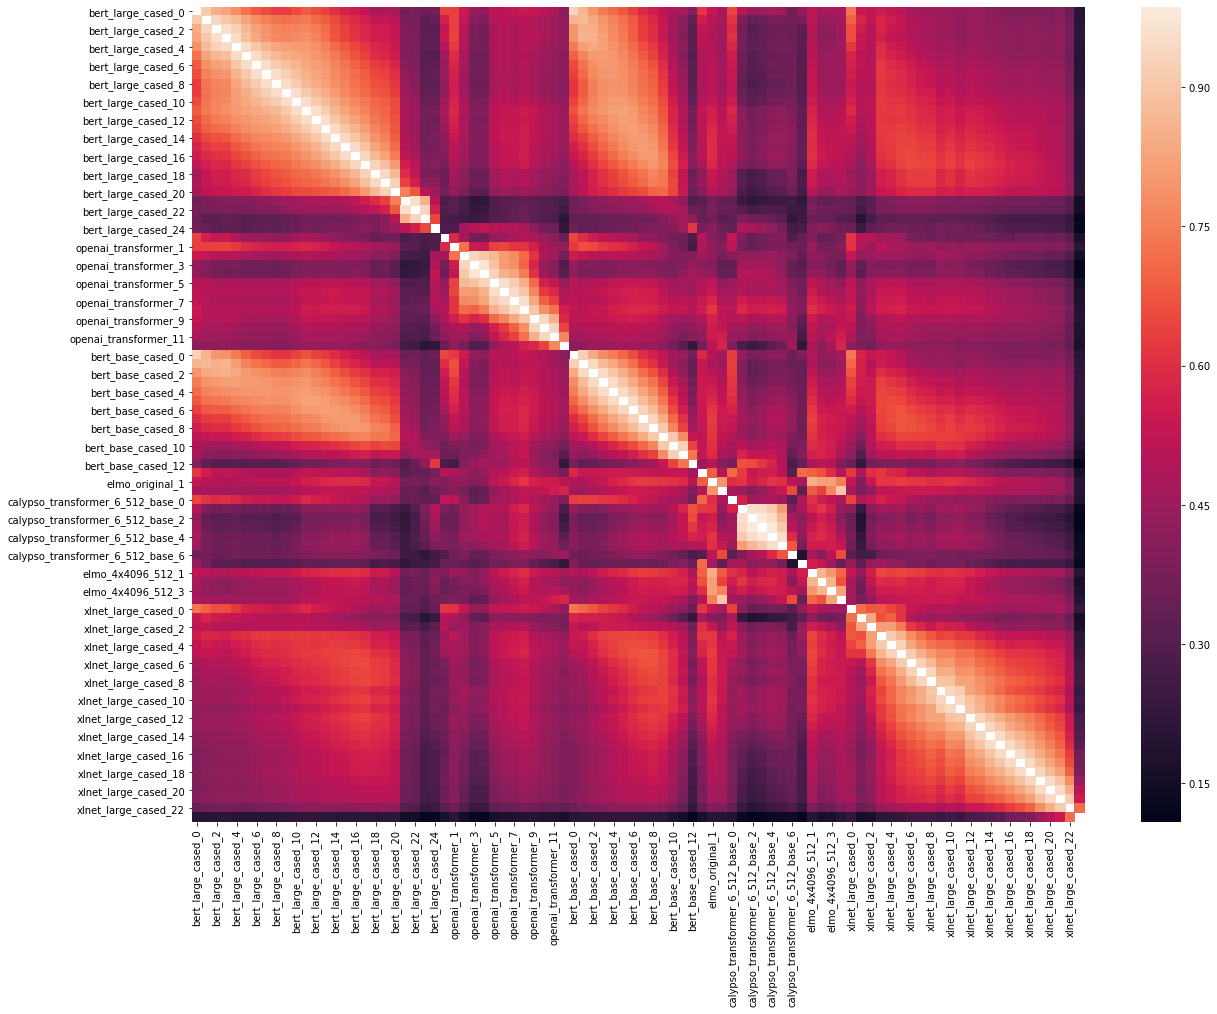

In [22]:
# lincka
sns.heatmap(lincka_df.reindex(lincka_df.columns))

In [23]:
# comparing models
# use lincka
model1 = "bert_base_cased"
model2 = "bert_large"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

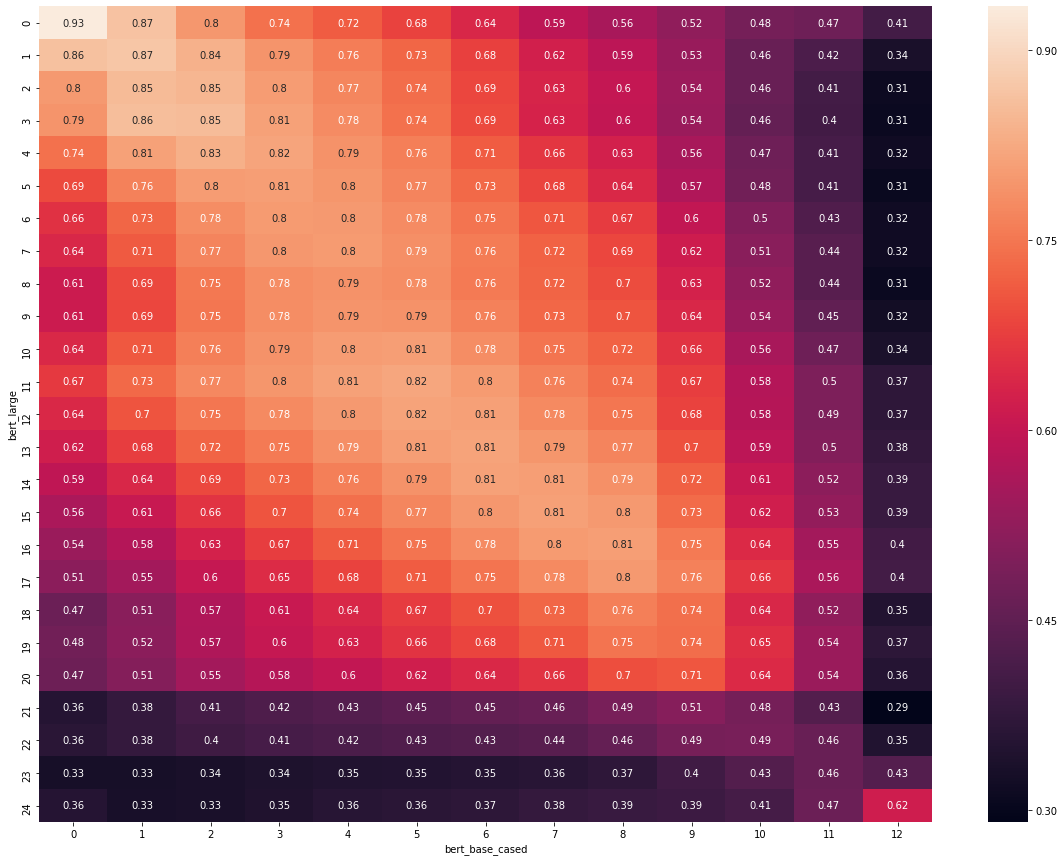

In [24]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()